<a href="https://colab.research.google.com/github/dreizehnutters/colab_notebooks/blob/master/KI_ae_in_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import argparse
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [0]:
# hyperparameters
parser = argparse.ArgumentParser(description='AE MNIST Example ()')
parser.add_argument('--batch-size', type=int, default=128, metavar='N', help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=3, metavar='N', help='number of epochs to train (default: 3)')
parser.add_argument('--rate', type=float, default=0.01, metavar='F', help='number of epochs to train (default: 0.01)')
parser.add_argument('--no-cuda', action='store_true', default=False, help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1337, metavar='S', help='random seed (default: 1337)')
parser.add_argument('--log-interval', type=int, default=25, metavar='N', help='how many batches to wait before logging training status')
args = args = parser.parse_args(args=[])
torch.manual_seed(args.seed)
device = torch.device("cuda")

In [0]:
# download MNIST
mnist_train = datasets.MNIST("./", train=True,
transform=transforms.ToTensor(), target_transform=None, download=True)

# set data loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=args.batch_size,shuffle=True)

In [0]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),   # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 14 x 14
                      )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 7 x 7
                        nn.ReLU()
                      )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out.view(args.batch_size, -1)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
                            nn.ConvTranspose2d(256,128,3,2,1,1), # batch x 128 x 14 x 14
                            nn.ReLU(),
                            nn.BatchNorm2d(128),
                            nn.ConvTranspose2d(128,128,3,1,1),   # batch x 128 x 14 x 14
                            nn.ReLU(),
                            nn.BatchNorm2d(128),
                            nn.ConvTranspose2d(128,64,3,1,1),    # batch x 64 x 14 x 14
                            nn.ReLU(),
                            nn.BatchNorm2d(64),
                            nn.ConvTranspose2d(64,64,3,1,1),     # batch x 64 x 14 x 14
                            nn.ReLU(),
                            nn.BatchNorm2d(64)
                        )
        self.layer2 = nn.Sequential(
                            nn.ConvTranspose2d(64,32,3,1,1),     # batch x 32 x 14 x 14
                            nn.ReLU(),
                            nn.BatchNorm2d(32),
                            nn.ConvTranspose2d(32,32,3,1,1),     # batch x 32 x 14 x 14
                            nn.ReLU(),
                            nn.BatchNorm2d(32),
                            nn.ConvTranspose2d(32,1,3,2,1,1),    # batch x 1 x 28 x 28
                            nn.ReLU()
                        )

    def forward(self, x):
        out = x.view(args.batch_size, 256, 7, 7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [0]:
encoder = Encoder().cuda()
decoder = Decoder().cuda()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=args.rate)

In [0]:
# train
for epoch in range(1, args.epochs+1):
    for batch_idx, (image, _) in enumerate(train_loader):
        if image.shape[0] < args.batch_size:
            break
        noise = torch.rand(args.batch_size, 1, 28, 28)
        image_n = torch.mul(image+0.25, 0.1 * noise)
        optimizer.zero_grad()
        output = encoder(image_n.to(device))
        output = decoder(output)
        loss = loss_func(output, image.to(device))
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print(f'epoch {epoch} [{batch_idx * len(image)}/{len(train_loader.dataset)}]\tloss@{(loss.item()):.6f} ')
    print(f'epoch [{epoch}/{args.epochs}] ==> loss@{loss.item():.6f}')

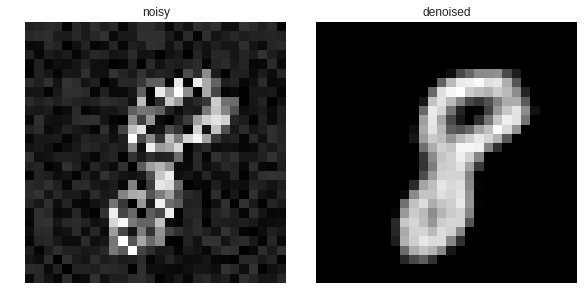

In [0]:
#plot results
noi = image_n[42].cpu().data.numpy()[0]
out = output[42].cpu().data.numpy()[0]
fig, axs = plt.subplots(1, 2, constrained_layout=True)
axs[0].imshow(noi, cmap='gray')
axs[0].set_title('noisy')
axs[0].axis('off')
axs[1].imshow(out, cmap="gray")
axs[1].set_title('denoised')
axs[1].axis('off')
plt.show()